# Titanic — Data Preprocessing Notebook

Mục tiêu: chuẩn hoá dữ liệu, xử lý missing, tạo feature, mã hoá, chuẩn hoá số và lưu dataset đã xử lý.

In [147]:
# 0. Thiết lập môi trường
import os, random
import numpy as np, pandas as pd
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Thư mục lưu kết quả (chạy lần đầu nếu cần)
os.makedirs('data\processed', exist_ok=True)
os.makedirs('data\pic', exist_ok=True)

# Path tới dữ liệu - chỉnh nếu cần
DATA_PATH = 'data/train.csv'

## 1) Load dữ liệu và kiểm tra nhanh và loại bỏ cột không dùng

In [148]:
# 1. Load dữ liệu
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
display(df.head())

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [149]:
#2. Loại bỏ cột không dùng

drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

print(f"🧹 Đã xóa {len(drop_cols)} cột không cần thiết:", drop_cols)
print("✅ Dữ liệu sẵn sàng cho bước encode & scale.")
display(df.head())


🧹 Đã xóa 4 cột không cần thiết: ['Name', 'Ticket', 'Cabin', 'PassengerId']
✅ Dữ liệu sẵn sàng cho bước encode & scale.


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 🧹 Loại bỏ các cột không cần thiết

Trong quá trình tiền xử lý, ba cột **`Cabin`**, **`Name`**, và **`PassengerId`** được loại bỏ khỏi tập dữ liệu vì các lý do sau:

#### 🔸 `Cabin`
- **Tỉ lệ dữ liệu thiếu (missing rate)** quá cao — hơn 75% các dòng không có giá trị `Cabin`.  
- Nếu cố gắng điền giá trị hoặc mã hoá, kết quả sẽ **không phản ánh được quy luật thật sự**, đồng thời **làm nhiễu mô hình**.  
- Mặc dù có thể trích xuất ký tự đầu (ví dụ A–G) để thể hiện vị trí khoang, nhưng do độ phủ thấp và phân bố không đều, nên **đặc trưng này không đáng tin cậy** cho mô hình huấn luyện.

#### 🔸 `Name`
- Cột `Name` là **chuỗi văn bản dài**, chứa thông tin họ tên hành khách — phần lớn **không mang ý nghĩa trực tiếp cho dự đoán sống sót**.  
- Tuy nhiên, **một phần nhỏ của cột này (tiêu đề – Title)** có giá trị (ví dụ: *Mr, Mrs, Miss, Master*), nên nhóm đã **trích xuất riêng cột `Title`** trước khi loại bỏ `Name`.  
- Sau khi trích xuất xong, phần tên đầy đủ không còn hữu ích → **loại bỏ để giảm nhiễu và đơn giản hoá mô hình.**

#### 🔸 `PassengerId`
- Là **mã định danh duy nhất** cho từng hành khách — không phải đặc trưng liên quan tới hành vi hay khả năng sống sót.  
- Nếu giữ lại, mô hình có thể **học nhầm “mã định danh” như đặc trưng**, làm sai lệch kết quả → **nên loại bỏ hoàn toàn.**

---

### ✅ Kết luận

> Việc loại bỏ các cột trên giúp:  
> - Giảm nhiễu trong dữ liệu huấn luyện.  
> - Tránh overfitting vào thông tin không mang ý nghĩa dự báo.  
> - Đơn giản hoá pipeline, tập trung vào các đặc trưng thực sự quan trọng như *Giới tính, Tuổi, Pclass, Fare, FamilySize, v.v.*

## 2) Kiểm tra missing và xử lý, Feature engineering

In [150]:
# 2. Missing & dtypes & basic stats
missing = df.isnull().sum()
print("\n Missing values per column:\n", missing[missing > 0])
display(df.describe(include='all').T)

df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))


 Missing values per column:
 Age         177
Embarked      2
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
# Family features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Extract Title từ Name (đã bỏ cột Name nên thêm lại tạm thời)
# Nếu file gốc không còn cột Name thì bỏ qua
if 'Title' not in df.columns:
    def extract_title(name):
        if pd.isna(name): return 'Unknown'
        title = name.split(',')[1].split('.')[0].strip()
        if title in ['Mr','Mrs','Miss','Master']:
            return title
        return 'Rare'
    if 'Name' in df.columns:
        df['Title'] = df['Name'].apply(extract_title)
    else:
        df['Title'] = 'Unknown'

# Age imputation (Pclass + Title median)
df['Age'] = df.groupby(['Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))
df['Age'] = df['Age'].fillna(df['Age'].median())

# AgeBin & FareBand
df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,20,40,60,120],
                      labels=['Child','Teen','Adult','MidAge','Senior'])

try:
    df['FareBand'] = pd.qcut(df['Fare'], 4, labels=False, duplicates='drop')
except ValueError:
    df['FareBand'] = pd.qcut(df['Fare'].rank(method='first'), 4, labels=False)

### Giải thích chi tiết

- **Embarked:** Điền giá trị thiếu bằng *mode* (giá trị xuất hiện nhiều nhất). Vì đây là biến categorical (bến cảng) và thường có 1 giá trị chiếm ưu thế, dùng mode là hợp lý.

- **Fare:** Giá vé khác nhau rõ rệt theo *Pclass* (hạng vé). Do đó ta điền `Fare` bị thiếu bằng **median theo từng Pclass** — cách này bảo toàn đặc trưng phân bố giá giữa các hạng vé.

- **FamilySize & IsAlone:** Tổng số thành viên trong gia đình trên tàu là `SibSp + Parch + 1`. `IsAlone` (1 nếu một mình) là một biến mạnh cho việc dự đoán khả năng sống sót (một mình thường có xác suất khác).

- **Age (chiến lược nâng cao):** Tuổi có phân bố khác nhau giữa các tầng xã hội và danh xưng (Title). Ta:
  1. Trích `Title` từ `Name` (Mr, Miss, Mrs, Master, Rare).
  2. Tính median `Age` theo nhóm `(Pclass, Title)`.
  3. Điền giá trị thiếu `Age` bằng median nhóm tương ứng.
  4. Nếu một nhóm không có median (ví dụ không có mẫu), ta fallback bằng median chung của cột `Age`.
  > Lý do: cách này thể hiện thông tin cấu trúc xã hội — cùng Title + Pclass thường có phân bố tuổi tương đồng.

- **AgeBin & FareBand:** Tạo nhóm rời rạc từ `Age` và `Fare` giúp:
  - Giảm ảnh hưởng outliers,
  - Giúp một số model (ví dụ tree-based) học quy luật nhóm tốt hơn,
  - Cung cấp biến giải thích trực quan cho báo cáo.

**Thực thi kỹ thuật:**  
- Sử dụng `groupby(...).transform()` để fill Age một cách vectorized — nhanh và an toàn.  
- Dùng `pd.qcut(..., duplicates='drop')` hoặc fallback `rank()` nếu qcut gặp vấn đề với nhiều giá trị giống nhau.


# 3) Chuẩn hóa, mã hóa & lưu dữ liệu tiền xử lý (preprocessed Titanic dataset)

Sau khi đã hoàn thiện các bước **feature engineering**, ta cần:
1. **Mã hóa (encoding)** các biến dạng chữ (categorical) thành dạng số.  
2. **Chuẩn hóa (scaling)** các biến liên tục (Age, Fare, FamilySize, ...) để tránh chênh lệch độ lớn.  
3. **Xuất dữ liệu sạch** thành `.csv` phục vụ bước huấn luyện mô hình (`titanic_model.ipynb`).

Mục tiêu là tạo một **pipeline**, sẵn sàng để chạy model sau này.


In [152]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import os

# ----- 1️⃣ Xác định & lọc các cột -----
target_col = 'Survived'

# Chọn cột categorical & numerical
cat_cols = ['Sex', 'Embarked', 'Title', 'AgeBin']
num_cols = ['Age', 'Fare', 'FamilySize']

# Tự động kiểm tra loại bỏ target nếu lỡ có trong danh sách
if target_col in cat_cols:
    cat_cols.remove(target_col)
if target_col in num_cols:
    num_cols.remove(target_col)

print(f"🎯 Cột categorical: {cat_cols}")
print(f"🎯 Cột numerical: {num_cols}")

# ----- 2️⃣ Encode các cột categorical -----
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

print(f"✅ Đã mã hóa {len(cat_cols)} cột categorical:", cat_cols)

# ----- 3️⃣ Chuẩn hóa các cột numerical -----
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print(f"✅ Đã chuẩn hóa {len(num_cols)} cột numerical:", num_cols)

# ----- 4️⃣ Lưu dữ liệu tiền xử lý -----
os.makedirs("data/processed", exist_ok=True)
output_path = "data/processed/titanic_train_preprocessed.csv"
df.to_csv(output_path, index=False)

print("\n📊 Kích thước dữ liệu sau xử lý:", df.shape)
print(f"💾 Đã lưu file dữ liệu tiền xử lý tại: {output_path}")

# ----- 5️⃣ Hiển thị mẫu dữ liệu -----
display(df.head())

🎯 Cột categorical: ['Sex', 'Embarked', 'Title', 'AgeBin']
🎯 Cột numerical: ['Age', 'Fare', 'FamilySize']
✅ Đã mã hóa 4 cột categorical: ['Sex', 'Embarked', 'Title', 'AgeBin']
✅ Đã chuẩn hóa 3 cột numerical: ['Age', 'Fare', 'FamilySize']

📊 Kích thước dữ liệu sau xử lý: (891, 13)
💾 Đã lưu file dữ liệu tiền xử lý tại: data/processed/titanic_train_preprocessed.csv


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBand
0,0,3,1,-0.533834,1,0,-0.502445,2,0.059160,0,0,0,0
1,1,1,0,0.674891,1,0,0.786845,0,0.059160,0,0,0,3
2,1,3,0,-0.231653,0,0,-0.488854,2,-0.560975,1,0,0,1
3,1,1,0,0.448255,1,0,0.420730,2,0.059160,0,0,0,3
4,0,3,1,0.448255,0,0,-0.486337,2,-0.560975,1,0,0,1


### Giải thích chi tiết

- **Categorical Encoding**: Các biến định tính (`Sex`, `Embarked`, `Title`, `AgeBin`) được mã hoá bằng *LabelEncoder*, biến chúng thành giá trị số để mô hình có thể xử lý.
- **Numerical Scaling**: Các biến định lượng (`Age`, `Fare`, `FamilySize`) được chuẩn hoá về cùng phân phối chuẩn bằng *StandardScaler*, giúp mô hình hội tụ nhanh và ổn định hơn.
- **Output**: Tập dữ liệu sau khi mã hoá và chuẩn hoá được lưu tại:  
  `data/processed/titanic_train_preprocessed.csv`

Cấu trúc sau xử lý:  
Tất cả đặc trưng đều ở dạng số (`int64`, `float64`), không còn giá trị thiếu,  
và sẵn sàng cho các thuật toán Machine Learning (Logistic Regression, Decision Tree, v.v.).

In [153]:
#Lưu dữ liệu đã xử lý
output_path = "data/processed/titanic_train_preprocessed.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)

print(f"\n💾 Đã lưu file tiền xử lý tại: {output_path}")
print("📊 Kích thước dữ liệu sau xử lý:", df.shape)
display(df.head())


💾 Đã lưu file tiền xử lý tại: data/processed/titanic_train_preprocessed.csv
📊 Kích thước dữ liệu sau xử lý: (891, 13)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBand
0,0,3,1,-0.533834,1,0,-0.502445,2,0.059160,0,0,0,0
1,1,1,0,0.674891,1,0,0.786845,0,0.059160,0,0,0,3
2,1,3,0,-0.231653,0,0,-0.488854,2,-0.560975,1,0,0,1
3,1,1,0,0.448255,1,0,0.420730,2,0.059160,0,0,0,3
4,0,3,1,0.448255,0,0,-0.486337,2,-0.560975,1,0,0,1


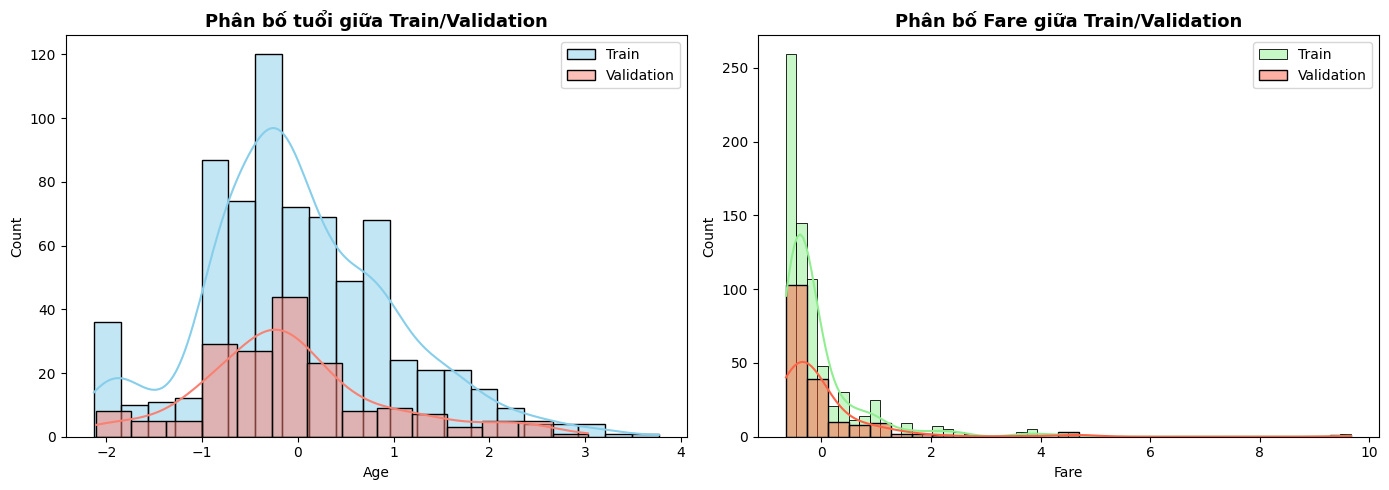

Biểu đồ đã được lưu thành công tại: data/pic/train_val_distribution.png


In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# So sánh phân bố giữa train và validation
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(X_train['Age'], color='skyblue', kde=True, label='Train')
sns.histplot(X_val['Age'], color='salmon', kde=True, label='Validation')
plt.title("Phân bố tuổi giữa Train/Validation", fontsize=13, fontweight='bold')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(X_train['Fare'], color='lightgreen', kde=True, label='Train')
sns.histplot(X_val['Fare'], color='tomato', kde=True, label='Validation')
plt.title("Phân bố Fare giữa Train/Validation", fontsize=13, fontweight='bold')
plt.legend()

plt.tight_layout()

output_path = "data/pic/train_val_distribution.png"
plt.savefig(output_path)

plt.show()
print(f"Biểu đồ đã được lưu thành công tại: {output_path}")

### 🔍 Giải thích

- **StandardScaler**: đảm bảo các biến liên tục có trung bình = 0, độ lệch chuẩn = 1.  
  Điều này giúp mô hình giảm hiện tượng *gradient vanishing* và *weight bias*.

- **Train/Validation split**:  
  Dữ liệu validation giúp kiểm tra độ tổng quát (generalization) của mô hình.  
  Dùng `stratify=y` để giữ tỉ lệ `Survived` cân bằng giữa 2 tập.

- **Lưu scaler và dữ liệu**:  
  Giúp dễ dàng *reuse* ở bước huấn luyện (`titanic_model.ipynb`) mà không bị lệch giá trị scale.

- **Biểu đồ phân bố**:  
  Cho phép ta trực quan hoá để đảm bảo 2 tập có phân bố tương đồng (đặc biệt quan trọng với dữ liệu nhỏ).